# data anlysis and ML

- 这是给出最佳结果的特征工程方法。
- 我们已将“RECOVERING”类视为“BROKEN”类，并且我们确实继续创建滚动窗口。
- 我们使用 10 分钟的窗口大小，并且我们在 5 分钟前预测了所有失败。
- 对于某些故障，我们会在 20 分钟前收到警告，最好尽快收到故障警告。

In [18]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.metrics import roc_auc_score

In [19]:
data=pd.read_csv('data/combine_sensors/sensor.csv')
print(data.head(3))
print('all class labels:',data['machine_status'].unique())
print('\n\n dataset length=', len(data))

   Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0           0  2021-04-01 00:00:00   2.465394   47.09201    53.2118   
1           1  2021-04-01 00:01:00   2.465394   47.09201    53.2118   
2           2  2021-04-01 00:02:00   2.444734   47.35243    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0   46.31076   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1   46.31076   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2   46.39757   638.8889   73.54598   13.32465   16.03733  ...   41.66666   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65.68287   50.92593  38.194440   157.9861   67.70834   
1  39.641200   65.68287   50.92593  38.194440   157.9861   67.70834   
2  39.351852   65.39352   51.21528  38.194443   155.9606   67.12963   

   sensor_50  sensor_51  machine_status  
0   243.0556   201.3889          NORMAL  
1   243.0556   201.3889          NORMAL  

### 统计和分析卷曲结构传感器报告失败日期和恢复时间

In [21]:
df_temp=data[['timestamp','machine_status']]
df_temp['machine_status'][df_temp['machine_status']=='BROKEN']= 1
df_temp['machine_status'][df_temp['machine_status']=='NORMAL']= 0
df_temp['machine_status'][df_temp['machine_status']=='RECOVERING']= -1

f=1
for i in df_temp[df_temp['machine_status']==1].index:
    j=i+1
    temp=0
    while df_temp['machine_status'][j] == -1:
        temp=temp+1
        j=j+1
    print('for failure {0} at {2}, recovering time is {1} hours'.format(f,temp/60,df_temp['timestamp'][i]))
    f=f+1

for failure 1 at 2021-04-12 21:55:00, recovering time is 15.733333333333333 hours
for failure 2 at 2021-04-18 00:30:00, recovering time is 51.833333333333336 hours
for failure 3 at 2021-05-19 03:18:00, recovering time is 21.866666666666667 hours
for failure 4 at 2021-05-25 00:30:00, recovering time is 10.083333333333334 hours
for failure 5 at 2021-06-28 22:00:00, recovering time is 139.83333333333334 hours
for failure 6 at 2021-07-08 00:11:00, recovering time is 0.6833333333333333 hours
for failure 7 at 2021-07-25 14:00:00, recovering time is 1.25 hours


# FE:
- We are using roling window method to create feature set, for each window we are going to take min, max, standerd deviation, midian and mean.
- We are using window of 10 samples and we are preding failure 5 minutes befor it happen.
- we are using window spacing of 1.
- if samples are like s1,s2,s3....... then 1st window is s1 - s10 and 2nd should be s2-s11 and so on. 
- Here we are removing all the sensor which is not changing with the class label, we have found it in EDA.
- Since the recovering appear after failure means the recovering state is not a normal state hence we are considering the 'RECOVERING' class as a 'BROKEN' class and kept it as it is in the dataset.
- Windows are continuous rolling window means, we are nor dropping any part of the dataset as we did in the previous approach where we removed the recovering state with that we  skipped each broken window for prediction of the next failure.

In [22]:
data.drop(['sensor_15','Unnamed: 0','sensor_01','sensor_03','sensor_14','sensor_16','sensor_17','sensor_18','sensor_19','sensor_20','sensor_21',
           'sensor_22','sensor_23','sensor_24','sensor_25','sensor_26','sensor_27','sensor_28','sensor_29','sensor_30',
           'sensor_31','sensor_33','sensor_34','sensor_37','sensor_36','sensor_48'],
          inplace=True,axis=1) #droping unwanted feature

## 填充 NA 值
- 关于缺失的数据，我们需要进行填充
- 我已经用特征的平均值填充了特定特征的所有 NA 值。
- 我选择了 50% 的数据，然后找出填充 NA 的平均值，因为这 50% 的部分我们将用于训练

In [23]:
mean=data.iloc[0:int((data.shape[0]*50)/100)][data.columns[1:-1]].mean().values
for i in tqdm(range(1,len(data.columns)-1)):
    col=data.columns[i]
    data[col]=data[col].fillna(mean[i-1])
np.save(open('data/NA_replace','wb'),mean)# saving mean for to use in 

  0%|          | 0/27 [00:00<?, ?it/s]

In [28]:
# 分类变量转化为数值变量

print('我们用 0 替换普通类，将其他 2 类替换为 1', '#'*20)

def map_fun(x):
    if x=='NORMAL':
        return 0
    else:
        return 1

data['machine_status']=data.machine_status.map(map_fun)

我们用 0 替换普通类，将其他 2 类替换为 1 ####################


In [7]:
# creating dataframe feature name.
columns=[]
for col in data.columns[1:-1]:
    columns.append('s{0}_median'.format(col[7:])) #to select sensor number
    columns.append('s{0}_mean'.format(col[7:]))
    columns.append('s{0}_std'.format(col[7:]))
    columns.append('s{0}_min'.format(col[7:]))
    columns.append('s{0}_max'.format(col[7:]))
columns.append('machine_status')

In [8]:
# create rolling window features
w=10

X = []
for i in data.columns[1:]:
    X1,X2,X3,X4,X5,X6=[],[],[],[],[],[]
    if not i =='machine_status':
        X1.append(data[i].rolling(w).median()) #creating mean min etc for each sensor window
        X2.append(data[i].rolling(w).mean())
        X3.append(data[i].rolling(w).std())
        X4.append(data[i].rolling(w).min())
        X5.append(data[i].rolling(w).max())
        fea_data = np.hstack([np.array(X1).reshape(-1,1),np.array(X2).reshape(-1,1),\
                       np.array(X3).reshape(-1,1),np.array(X4).reshape(-1,1),\
                       np.array(X5).reshape(-1,1)])
    else:    
        X6.append(data[i].rolling(w).max()) # taking class label, if there is even singal failure we consider whole window as failure window.
        fea_data=np.array(X6).reshape(-1,1)
    X.append(fea_data)

In [9]:
temp_data = X[0]
for i in range(1,len(X)):
    temp_data = np.hstack([temp_data, X[i]])

data_df = pd.DataFrame(temp_data, columns=columns)

In [10]:
data_df=data_df.loc[w-1:] #removing w-1 rows from start because that all are NAN, it happen because size of data frame same as-- 
#size of orignal data frame but, it should be w-1 less than orignal dataframe.

In [11]:
# we are shifting dataframe by 2w, because we want to predict failure w minuts before. 
temp1=data_df['machine_status'].iloc[w+w:].values
temp2=data['timestamp'].iloc[w:-(w+w-1)].values
data_df=data_df.iloc[:-(w+w)].copy()
data_df['machine_status']=temp1
data_df['timestamp']=temp2

In [12]:
data_df.to_csv('final.csv')

# MODELING:

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from sklearn.metrics import  recall_score, confusion_matrix
from zipfile import ZipFile

In [14]:
X=pd.read_csv('final.csv',index_col=0)
X.head()

,s00_median,s00_mean,s00_std,s00_min,s00_max,s02_median,s02_mean,s02_std,s02_min,s02_max,...,s50_std,s50_min,s50_max,s51_median,s51_mean,s51_std,s51_min,s51_max,machine_status,timestamp
9,2.454572,2.454966,0.008337,2.444734,2.465394,53.1684,53.18576,0.022412,53.1684,53.2118,...,1.825207,240.162,246.5278,201.3889,201.64930,1.033864,200.2315,203.7037,0.0,2018-04-01 00:10:00
10,2.454572,2.454867,0.008205,2.444734,2.465394,53.1684,53.17708,0.027449,53.1250,53.2118,...,3.285012,240.162,250.8681,201.3889,201.50462,1.167013,199.9421,203.7037,0.0,2018-04-01 00:11:00
11,2.451621,2.452801,0.007854,2.444734,2.464410,53.1684,53.17274,0.024636,53.1250,53.2118,...,4.587768,240.162,253.1829,201.2442,201.38888,1.235168,199.9421,203.7037,0.0,2018-04-01 00:12:00
12,2.454572,2.454375,0.007632,2.444734,2.464410,53.1684,53.16406,0.024636,53.1250,53.2118,...,5.279667,240.162,253.1829,201.2442,201.24420,0.995350,199.9421,203.1250,0.0,2018-04-01 00:13:00
13,2.451621,2.453195,0.007495,2.444734,2.464410,53.1684,53.16406,0.024636,53.1250,53.2118,...,5.484062,240.162,253.1829,201.2442,201.21526,0.937092,199.9421,202.8356,0.0,2018-04-01 00:14:00


## Train test split
- As we know we have temporal data so there are chances of data that may vary with time then the result will also vary. hence it is better to split our data based on time like make older data for the train and newer for the test. 
- We have only 7 failure data points from which we made 10 data points of each in the FE section, we decided to use 4 data point for train and 2 for CV and 1 for a test. 
- We will use 50% data for train and 25% for each CV and test.

In [15]:
X_train=X.iloc[0:int((X.shape[0]*50)/100)]
X_cv=X.iloc[int((X.shape[0]*50)/100):int((X.shape[0]*75)/100)]
X_test=X.iloc[int((X.shape[0]*75)/100):]
print('train shape:',X_train.shape)
print('cv shape:',X_cv.shape)
print('test shape:',X_test.shape)

train shape: (110145, 137)
cv shape: (55073, 137)
test shape: (55073, 137)


## Checking for data leakage
-  we have 10 points for each single failure hence there is chances of placing some points in train and some points in cv those belong to singal failure. i am printing dates so that i can check data leakage.

In [16]:

X_train_fail=X_train[X_train['machine_status']==1].copy()
X_train_fail['timestamp']=pd.to_datetime(X_train_fail['timestamp'])
g1=X_train_fail.groupby(by=X_train_fail['timestamp'].dt.date)
print('train failure dates:\n',g1.groups.keys())

X_cv_fail=X_cv[X_cv['machine_status']==1].copy()
X_cv_fail['timestamp']=pd.to_datetime(X_cv_fail['timestamp'])
g2=X_cv_fail.groupby(by=X_cv_fail['timestamp'].dt.date)
print('cv failure dates:\n',g2.groups.keys())

train failure dates:
 dict_keys([datetime.date(2018, 4, 12), datetime.date(2018, 4, 13), datetime.date(2018, 4, 18), datetime.date(2018, 4, 19), datetime.date(2018, 4, 20), datetime.date(2018, 5, 19), datetime.date(2018, 5, 20), datetime.date(2018, 5, 25)])
cv failure dates:
 dict_keys([datetime.date(2018, 6, 28), datetime.date(2018, 6, 29), datetime.date(2018, 6, 30), datetime.date(2018, 7, 1), datetime.date(2018, 7, 2), datetime.date(2018, 7, 3), datetime.date(2018, 7, 4), datetime.date(2018, 7, 7), datetime.date(2018, 7, 8)])


In [17]:
y_train = X_train['machine_status']
X_train = X_train.drop(['machine_status'], axis=1)
y_cv = X_cv['machine_status']
X_cv = X_cv.drop(['machine_status'], axis=1)
y_test = X_test['machine_status']
X_test = X_test.drop(['machine_status'], axis=1)

In [18]:
print('train labels count:\n',y_train.value_counts())
print('cv labels count:\n',y_cv.value_counts())
print('test labels count:\n',y_test.value_counts())

train labels count:
 0.0    104134
1.0      6011
Name: machine_status, dtype: int64
cv labels count:
 0.0    46622
1.0     8451
Name: machine_status, dtype: int64
test labels count:
 0.0    54988
1.0       85
Name: machine_status, dtype: int64


## Normalization:

In [19]:
with ZipFile('model_scaler.zip', 'w') as zipObj2: #storing all scaler function to use in inference time
    for col in X_train.columns[0:-1]:
        scaler = MinMaxScaler()
        X_train[col]=scaler.fit_transform(X_train[col].values.reshape(-1, 1))
        X_cv[col]=scaler.transform(X_cv[col].values.reshape(-1, 1))
        X_test[col]=scaler.transform(X_test[col].values.reshape(-1, 1))
        model_scaler = pickle.dump(scaler, open('model_scaler_{0}'.format(col), 'wb'))
        zipObj2.write('model_scaler_{0}'.format(col))
zipObj2.close()      

In [20]:
def plot_confusion_matrix(test_y, predict_y):
    """ this function print cunfusion matrix and recall matrix
    """
    labels = [0,1]
    C = confusion_matrix(test_y, predict_y,labels=labels)
    A =(((C.T)/(C.sum(axis=1))).T)
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(5,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(5,4))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## Random forest:

train confusion and recall matrix:

-------------------- Confusion matrix --------------------


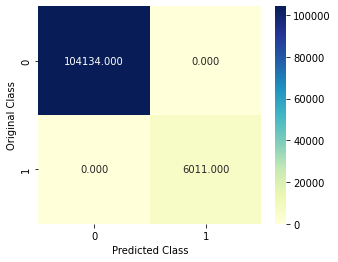

-------------------- Recall matrix (Row sum=1) --------------------


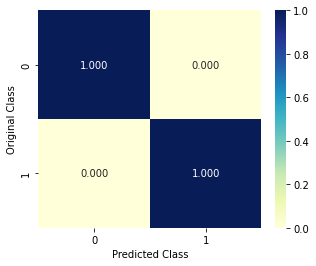

cv confusion and recall matrix:

-------------------- Confusion matrix --------------------


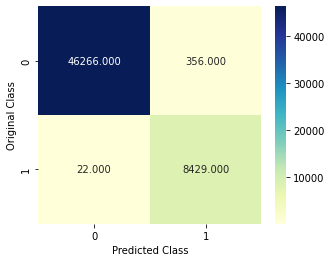

-------------------- Recall matrix (Row sum=1) --------------------


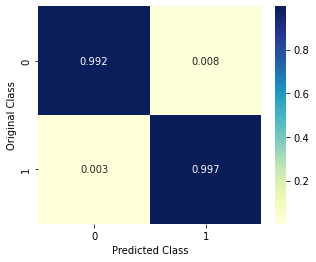

test confusion and recall matrix:

-------------------- Confusion matrix --------------------


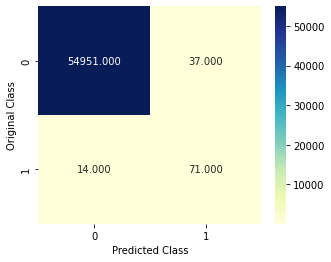

-------------------- Recall matrix (Row sum=1) --------------------


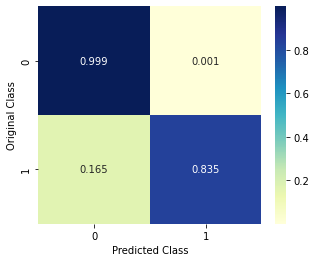

train AUC score: 1.0
cv AUC score: 0.99498448134299
test AUC score: 0.9958067856516287


In [21]:
clf = RandomForestClassifier(max_features='sqrt',n_jobs=-1,random_state=1)
clf.fit(X_train[X_train.columns[0:-1]], y_train)
print('train confusion and recall matrix:\n')
plot_confusion_matrix(y_train, clf.predict(X_train[X_train.columns[0:-1]]))
print('cv confusion and recall matrix:\n')
plot_confusion_matrix(y_cv, clf.predict(X_cv[X_train.columns[0:-1]]))
print('test confusion and recall matrix:\n')
plot_confusion_matrix(y_test, clf.predict(X_test[X_train.columns[0:-1]]))
print('train AUC score:',roc_auc_score(y_train, clf.predict_proba(X_train[X_train.columns[0:-1]])[:,1]))
print('cv AUC score:',roc_auc_score(y_cv, clf.predict_proba(X_cv[X_train.columns[0:-1]])[:,1]))
print('test AUC score:',roc_auc_score(y_test, clf.predict_proba(X_test[X_train.columns[0:-1]])[:,1]))

## Feature importance:

In [22]:
pickle.dump(clf, open('final_model', 'wb'))

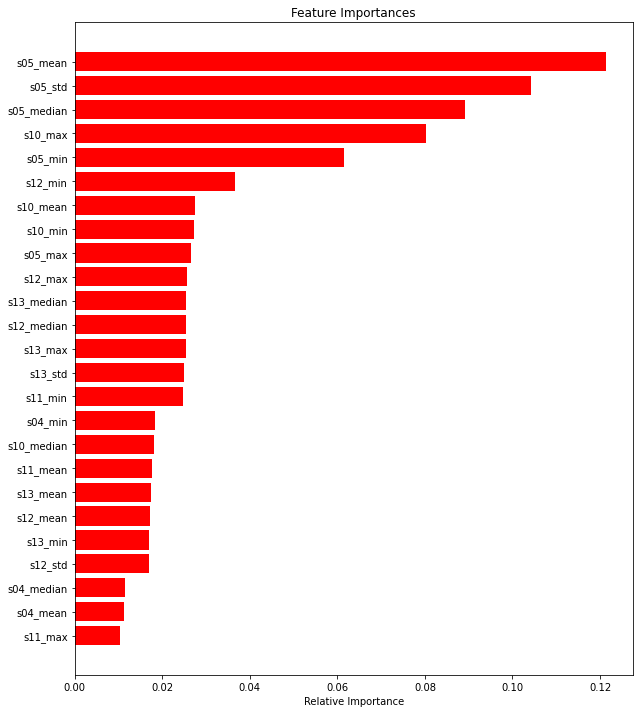

In [23]:
features = X_train.columns[0:-1]
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Analysis of false positive in cv data:
- we will take all samples for which we have predicted 1 and they are actually labeled as 0.
- after that, we will create groups by date to see all why that normal value are predicted as failure.

In [24]:
d=pd.DataFrame() #temp dataframe
d['time']=X_cv['timestamp']
d['true']=y_cv
d['pred']=clf.predict(X_cv[X_train.columns[0:-1]])
a=d[d['true']==0]
x=a[a['pred']==1]
x['time']=pd.to_datetime(x['time'])
g=x.groupby(by=x['time'].dt.date)
print('date of failure:',list(g.groups.keys())) 

date of failure: [datetime.date(2018, 6, 28), datetime.date(2018, 7, 4), datetime.date(2018, 7, 8), datetime.date(2018, 7, 17)]


/var/folders/dc/s7qx70fx44l4m7cvndrz2jsh0000gn/T/ipykernel_30342/3547995751.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['time']=pd.to_datetime(x['time'])


In [25]:
print('all FP points of date:',list(g.groups.keys())[0])
g.get_group(list(g.groups.keys())[0])

all FP points of date: 2018-06-28


,time,true,pred
127693,2018-06-28 16:14:00,0.0,1.0
127694,2018-06-28 16:15:00,0.0,1.0
127695,2018-06-28 16:16:00,0.0,1.0
127696,2018-06-28 16:17:00,0.0,1.0
127697,2018-06-28 16:18:00,0.0,1.0
...,...,...,...
128015,2018-06-28 21:36:00,0.0,1.0
128016,2018-06-28 21:37:00,0.0,1.0
128017,2018-06-28 21:38:00,0.0,1.0
128018,2018-06-28 21:39:00,0.0,1.0


- We have a failure on date 2018-06-28 at time 22:00:00 so it should get predicted at time 21:55:00. but we can see our model started giving warning of failure from 16:12:00, which means approx 6 hours before.
- this failure takes the highest time to recover among all failures, hence the cause of this failure might different from others, and due to this, we get  warnings before 6 hours.

In [26]:
print('all FP points of date:',list(g.groups.keys())[1])
g.get_group(list(g.groups.keys())[1])

all FP points of date: 2018-07-04


,time,true,pred
136420,2018-07-04 17:41:00,0.0,1.0
136421,2018-07-04 17:42:00,0.0,1.0
136422,2018-07-04 17:43:00,0.0,1.0
136423,2018-07-04 17:44:00,0.0,1.0
136424,2018-07-04 17:45:00,0.0,1.0
...,...,...,...
136492,2018-07-04 18:53:00,0.0,1.0
136493,2018-07-04 18:54:00,0.0,1.0
136494,2018-07-04 18:55:00,0.0,1.0
136495,2018-07-04 18:56:00,0.0,1.0


- a failure on 2018-06-28 took 6 days to recover, which means it recovers on date 2018-07-04.
- let we have window W4547, machine status in this window is 'RECOVERING'. next to next window W4549, our machine is recovered and now the status is 'NORMAL'.
- we are using W4547 to predict machine status at window W4549, how can we expect  from the data of recovering machine to give a prediction of the next normal state.
- here when the machine is in failure condition, it unable to predict the next normal state, which is totally fine because when the machine is in failure we don't care about the prediction of the machine's next state.
- these false positive points are not a bad prediction of our model.

In [27]:
print('all FP points of date:',list(g.groups.keys())[2])
g.get_group(list(g.groups.keys())[2])

all FP points of date: 2018-07-08


,time,true,pred
141162,2018-07-08 00:43:00,0.0,1.0
141166,2018-07-08 00:47:00,0.0,1.0
141167,2018-07-08 00:48:00,0.0,1.0
141168,2018-07-08 00:49:00,0.0,1.0
141169,2018-07-08 00:50:00,0.0,1.0
141170,2018-07-08 00:51:00,0.0,1.0
141172,2018-07-08 00:53:00,0.0,1.0
141173,2018-07-08 00:54:00,0.0,1.0
141174,2018-07-08 00:55:00,0.0,1.0
141175,2018-07-08 00:56:00,0.0,1.0


- here also the condition is the same as above.
- we have a failure at 00:11:00 on date 2018-07-08, which gets recovered in 40 minutes.
- here also in recovering state our model unable to predict the next normal statue which is ok.

In [28]:
print('all FP points of date:',list(g.groups.keys())[3])
g.get_group(list(g.groups.keys())[3])

all FP points of date: 2018-07-17


,time,true,pred
155007,2018-07-17 15:28:00,0.0,1.0
155008,2018-07-17 15:29:00,0.0,1.0
155009,2018-07-17 15:30:00,0.0,1.0
155010,2018-07-17 15:31:00,0.0,1.0
155011,2018-07-17 15:32:00,0.0,1.0
155012,2018-07-17 15:33:00,0.0,1.0
155013,2018-07-17 15:34:00,0.0,1.0
155014,2018-07-17 15:35:00,0.0,1.0
155015,2018-07-17 15:36:00,0.0,1.0
155016,2018-07-17 15:37:00,0.0,1.0


- we don't have any reason to justify these false positive points. these all points are actual false positive points.

# Analysis of false negative in cv data:

In [29]:
d=pd.DataFrame() #temp dataframe
d['time']=X_cv['timestamp']
d['true']=y_cv
d['pred']=clf.predict(X_cv[X_train.columns[0:-1]])
a=d[d['true']==1]
x=a[a['pred']==0]
x['time']=pd.to_datetime(x['time'])
g=x.groupby(by=x['time'].dt.date)
print('date of failure:',list(g.groups.keys())) 


date of failure: [datetime.date(2018, 7, 7), datetime.date(2018, 7, 8)]


/var/folders/dc/s7qx70fx44l4m7cvndrz2jsh0000gn/T/ipykernel_30342/1326950552.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['time']=pd.to_datetime(x['time'])


In [30]:
print('all FN points of date:',list(g.groups.keys())[0])
g.get_group(list(g.groups.keys())[0])

all FN points of date: 2018-07-07


,time,true,pred
141111,2018-07-07 23:52:00,1.0,0.0
141112,2018-07-07 23:53:00,1.0,0.0
141113,2018-07-07 23:54:00,1.0,0.0
141114,2018-07-07 23:55:00,1.0,0.0
141115,2018-07-07 23:56:00,1.0,0.0
141116,2018-07-07 23:57:00,1.0,0.0
141117,2018-07-07 23:58:00,1.0,0.0
141118,2018-07-07 23:59:00,1.0,0.0


- we have a failure at 2018-07-08 00:11:00, it should get predicted before 2018-07-08 00:06:00.
- we have machine status normal till 2018-07-07 23:59:00, we are not expecting from model to predict failure in this time.hence these false negative are not reducing our model's performance score.

In [31]:
print('all FN points of date:',list(g.groups.keys())[1])
g.get_group(list(g.groups.keys())[1])

all FN points of date: 2018-07-08


,time,true,pred
141119,2018-07-08 00:00:00,1.0,0.0
141120,2018-07-08 00:01:00,1.0,0.0
141121,2018-07-08 00:02:00,1.0,0.0
141122,2018-07-08 00:03:00,1.0,0.0
141123,2018-07-08 00:04:00,1.0,0.0
141152,2018-07-08 00:33:00,1.0,0.0
141153,2018-07-08 00:34:00,1.0,0.0
141155,2018-07-08 00:36:00,1.0,0.0
141156,2018-07-08 00:37:00,1.0,0.0
141157,2018-07-08 00:38:00,1.0,0.0


- we have a failure at 2018-07-08 00:11:00, we are predicting this failure 5 minutes before hence this 1st 5 false-negative doesn't matter.
- our model was in a recovering state after this failure till 00:52:00, in recovering state whichever status of our machine is predicted, we don't care about it.

# Analysis of false positive in test data:

In [32]:
d=pd.DataFrame() #temp dataframe
d['time']=X_test['timestamp']
d['true']=y_test
d['pred']=clf.predict(X_test[X_train.columns[0:-1]])
a=d[d['true']==0]
x=a[a['pred']==1]
x['time']=pd.to_datetime(x['time'])
g=x.groupby(by=x['time'].dt.date)
print('date of failure:',list(g.groups.keys())) 


date of failure: [datetime.date(2018, 7, 25), datetime.date(2018, 8, 14), datetime.date(2018, 8, 21)]


/var/folders/dc/s7qx70fx44l4m7cvndrz2jsh0000gn/T/ipykernel_30342/1831591341.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['time']=pd.to_datetime(x['time'])


In [33]:
print('all FP points of date:',list(g.groups.keys())[0])
g.get_group(list(g.groups.keys())[0])

all FP points of date: 2018-07-25


,time,true,pred
166505,2018-07-25 15:06:00,0.0,1.0
166506,2018-07-25 15:07:00,0.0,1.0
166507,2018-07-25 15:08:00,0.0,1.0
166508,2018-07-25 15:09:00,0.0,1.0
166509,2018-07-25 15:10:00,0.0,1.0
166510,2018-07-25 15:11:00,0.0,1.0
166511,2018-07-25 15:12:00,0.0,1.0
166512,2018-07-25 15:13:00,0.0,1.0
166513,2018-07-25 15:14:00,0.0,1.0
166514,2018-07-25 15:15:00,0.0,1.0


- here also the same condition we have seen for false positive in cv data.
- the failure is at 2018-07-25 14:00:00 which took aprrox 1 hour to get recovered. our model unable to predict the next normal state when machine is  in a failure state.

In [34]:
print('all FP points of date:',list(g.groups.keys())[1])
g.get_group(list(g.groups.keys())[1])

all FP points of date: 2018-08-14


,time,true,pred
195160,2018-08-14 12:41:00,0.0,1.0
195161,2018-08-14 12:42:00,0.0,1.0
195162,2018-08-14 12:43:00,0.0,1.0
195163,2018-08-14 12:44:00,0.0,1.0
195164,2018-08-14 12:45:00,0.0,1.0
195165,2018-08-14 12:46:00,0.0,1.0
195166,2018-08-14 12:47:00,0.0,1.0
195167,2018-08-14 12:48:00,0.0,1.0
195168,2018-08-14 12:49:00,0.0,1.0
195169,2018-08-14 12:50:00,0.0,1.0


In [35]:
print('all FP points of date:',list(g.groups.keys())[2])
g.get_group(list(g.groups.keys())[2])

all FP points of date: 2018-08-21


,time,true,pred
205045,2018-08-21 09:26:00,0.0,1.0
205046,2018-08-21 09:27:00,0.0,1.0
205047,2018-08-21 09:28:00,0.0,1.0
205048,2018-08-21 09:29:00,0.0,1.0
205049,2018-08-21 09:30:00,0.0,1.0


- these points are actually false positive, we don't have reason to justify these.

# Analysis of false negative in test data:

In [36]:
d=pd.DataFrame() #temp dataframe
d['time']=X_test['timestamp']
d['true']=y_test
d['pred']=clf.predict(X_test[X_train.columns[0:-1]])
a=d[d['true']==1]
x=a[a['pred']==0]
x['time']=pd.to_datetime(x['time'])
g=x.groupby(by=x['time'].dt.date)
print('date of failure:',list(g.groups.keys())) 

date of failure: [datetime.date(2018, 7, 25)]


/var/folders/dc/s7qx70fx44l4m7cvndrz2jsh0000gn/T/ipykernel_30342/937714930.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['time']=pd.to_datetime(x['time'])


In [37]:
print('all FN points of date:',list(g.groups.keys())[0])
g.get_group(list(g.groups.keys())[0])

all FN points of date: 2018-07-25


,time,true,pred
166420,2018-07-25 13:41:00,1.0,0.0
166421,2018-07-25 13:42:00,1.0,0.0
166422,2018-07-25 13:43:00,1.0,0.0
166423,2018-07-25 13:44:00,1.0,0.0
166424,2018-07-25 13:45:00,1.0,0.0
166425,2018-07-25 13:46:00,1.0,0.0
166426,2018-07-25 13:47:00,1.0,0.0
166427,2018-07-25 13:48:00,1.0,0.0
166428,2018-07-25 13:49:00,1.0,0.0
166429,2018-07-25 13:50:00,1.0,0.0


- we have failure at 2018-07-25 14:00:00, which should get predicted before 13:55:00.
- our model predicted normal for this failure till 13:54:00, which means we are predicting this failure at 13:55:00.

## conclusion:
### We have predicted all failure before 5 minutes, with false positive points on 3 dates. 1 in the cv dataset and 2 in the test dataset. for other false positive we have proper justification.